In [ ]:
import torch, platform, sys
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Python: 3.12.12
PyTorch: 2.8.0+cu126
CUDA available: False


In [ ]:
!pip -q install kaggle torch torchvision matplotlib


In [1]:
from pathlib import Path
import os

KAGGLE_TOKEN = Path("/root/.kaggle/kaggle.json")
if not KAGGLE_TOKEN.exists():
    from google.colab import files
    print(" Upload your Kaggle API token (kaggle.json). Get it from Kaggle: Account → Create New API Token.")
    uploaded = files.upload()
    os.makedirs("/root/.kaggle", exist_ok=True)
    Path("kaggle.json").rename(KAGGLE_TOKEN)
    KAGGLE_TOKEN.chmod(0o600)
print("Kaggle token ready ")


 Upload your Kaggle API token (kaggle.json). Get it from Kaggle: Account → Create New API Token.


Saving kaggle.json to kaggle.json
Kaggle token ready 


In [2]:
USE_DRIVE = False

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = Path("/content/drive/MyDrive/celeba")
else:
    DATA_DIR = Path("/content/celeba")

print("Data root:", DATA_DIR)


Data root: /content/celeba


In [3]:
# Clean and re-create folder
import shutil
if DATA_DIR.exists():
    shutil.rmtree(DATA_DIR)
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(" Downloading CelebA from Kaggle mirror …")
!kaggle datasets download -d jessicali9530/celeba-dataset -p "$DATA_DIR" -q
print("Download complete ")


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
Download complete 


In [4]:
import zipfile
from pathlib import Path

def unzip_all(root: Path):
    while True:
        zips = list(root.rglob("*.zip"))
        if not zips:
            break
        for z in zips:
            print("🗜️ Unzipping:", z.relative_to(root))
            with zipfile.ZipFile(z, "r") as f:
                f.extractall(z.parent)
            z.unlink()
    print("All zips extracted ")

unzip_all(DATA_DIR)


🗜️ Unzipping: celeba-dataset.zip
All zips extracted 


In [5]:
from pathlib import Path

def find_img_dir(root: Path, min_imgs=1000):
    best = None
    best_n = 0
    for p in root.rglob("*"):
        if p.is_dir():
            n = len(list(p.glob("*.jpg")))
            if n > best_n:
                best, best_n = p, n
    if best is None or best_n < min_imgs:
        raise RuntimeError(f"No JPGs found under {root}. Found {best_n} images total.")
    return best, best_n

IMG_DIR, N_IMGS = find_img_dir(DATA_DIR, min_imgs=1000)
print(" Using image folder:", IMG_DIR)
print(" Total JPGs:", N_IMGS)


 Using image folder: /content/celeba/img_align_celeba/img_align_celeba
 Total JPGs: 202599


In [6]:
from pathlib import Path
from PIL import Image
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#  Path to extracted CelebA images
IMG_DIR = Path("/content/celeba/img_align_celeba/img_align_celeba")
assert IMG_DIR.exists(), f" Folder not found: {IMG_DIR}"
print(f" Found folder: {IMG_DIR}")
print(f" Total JPGs: {len(list(IMG_DIR.glob('*.jpg')))}")
# --- Transformations ---
HR_SIZE = 128
SCALE   = 2
LR_SIZE = HR_SIZE // SCALE
hr_tf = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize((HR_SIZE, HR_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
])
to_pil = transforms.ToPILImage()
lr_from_hr = transforms.Compose([
    transforms.Resize((LR_SIZE, LR_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
])
# --- CelebA class ---
class CelebASR(Dataset):
    def __init__(self, img_dir: Path):
        self.paths = sorted(img_dir.glob("*.jpg"))
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found in {img_dir}")
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        pil = Image.open(self.paths[i]).convert("RGB")
        hr  = hr_tf(pil)
        lr  = lr_from_hr(to_pil(hr))
        return lr, hr

sr_ds = CelebASR(IMG_DIR)
print(f" Dataset ready: {len(sr_ds)} images")


 Found folder: /content/celeba/img_align_celeba/img_align_celeba
 Total JPGs: 202599
 Dataset ready: 202599 images


In [7]:
from torch.utils.data import DataLoader

sr_loader = DataLoader(sr_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
print(" DataLoader ready")


 DataLoader ready


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


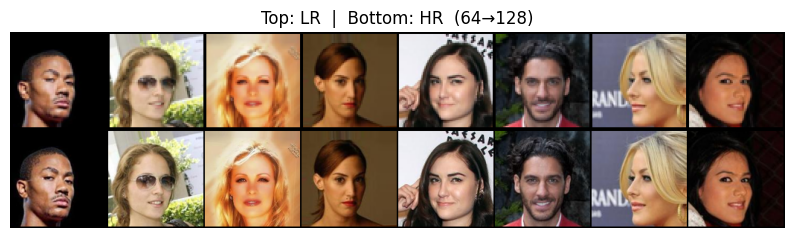

In [ ]:
from torchvision import utils
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

lr_batch, hr_batch = next(iter(sr_loader))

# Make separate grids
grid_lr = utils.make_grid(lr_batch[:8], nrow=8, padding=2)
grid_hr = utils.make_grid(hr_batch[:8], nrow=8, padding=2)

# Upsample LR grid to match HR grid height/width
grid_lr_up = F.interpolate(grid_lr.unsqueeze(0), size=grid_hr.shape[-2:], mode="nearest").squeeze(0)

grid = torch.cat([grid_lr_up, grid_hr], dim=1)

plt.figure(figsize=(10,6))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title(f"Top: LR  |  Bottom: HR  ({lr_batch.shape[-1]}→{hr_batch.shape[-1]})")
plt.show()


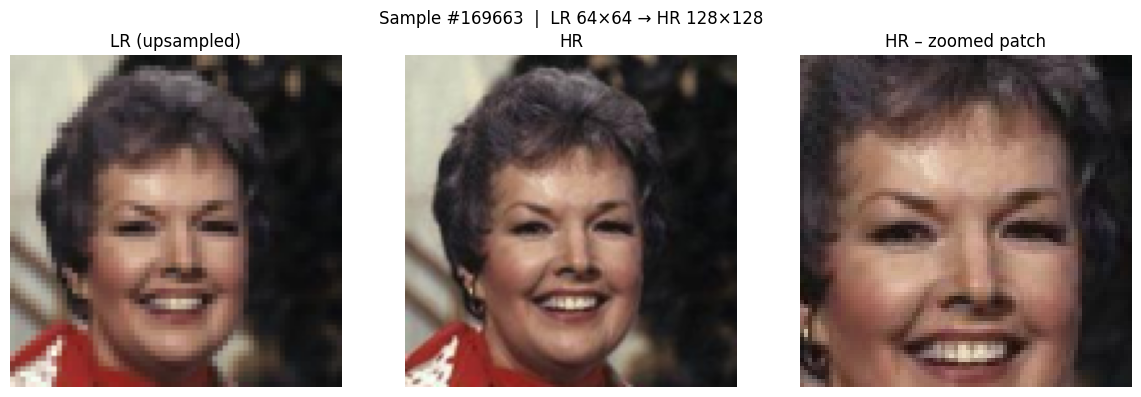

In [ ]:
import matplotlib.pyplot as plt
import torch, torch.nn.functional as F

# pick one random sample
i = torch.randint(0, len(sr_ds), (1,)).item()
lr, hr = sr_ds[i]
lr_up = F.interpolate(lr.unsqueeze(0), size=hr.shape[-2:], mode="nearest").squeeze(0)

# choose a patch window
H, W = hr.shape[-2:]
cy, cx, win = H//2, W//2, 40
sl = slice(cy-win, cy+win), slice(cx-win, cx+win)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(lr_up.permute(1,2,0));               ax[0].set_title("LR (upsampled)"); ax[0].axis("off")
ax[1].imshow(hr.permute(1,2,0));                  ax[1].set_title("HR");             ax[1].axis("off")
ax[2].imshow(hr[:,sl[0],sl[1]].permute(1,2,0));   ax[2].set_title("HR – zoomed patch"); ax[2].axis("off")
plt.suptitle(f"Sample #{i}  |  LR {lr.shape[-1]}×{lr.shape[-2]} → HR {hr.shape[-1]}×{hr.shape[-2]}")
plt.tight_layout()
plt.show()


In [ ]:
print("Total images in dataset:", len(sr_ds))
print("LR batch:", tuple(lr_batch.shape), "HR batch:", tuple(hr_batch.shape))


Total images in dataset: 202599
LR batch: (16, 3, 64, 64) HR batch: (16, 3, 128, 128)


In [ ]:
import torch
from torch.utils.data import Subset

N = len(sr_ds)
g = torch.Generator().manual_seed(42)
perm = torch.randperm(N, generator=g)

test_ratio, val_ratio = 0.05, 0.05
test_size = int(N * test_ratio)
val_size  = int(N * val_ratio)
train_size = N - val_size - test_size

train_idx = perm[:train_size]
val_idx   = perm[train_size:train_size+val_size]
test_idx  = perm[train_size+val_size:]

train_ds = Subset(sr_ds, train_idx.tolist())
val_ds   = Subset(sr_ds, val_idx.tolist())
test_ds  = Subset(sr_ds, test_idx.tolist())

print(f"Split sizes  ▶  train: {len(train_ds)}  val: {len(val_ds)}  test: {len(test_ds)}")


Split sizes  ▶  train: 182341  val: 10129  test: 10129


In [8]:
from google.colab import drive
import os

drive.mount('/content/drive')

out_dir = "/content/drive/MyDrive/celeba/final_tensors_sharded"
os.makedirs(out_dir, exist_ok=True)

print(" Output folder ready:", out_dir)



Mounted at /content/drive
 Output folder ready: /content/drive/MyDrive/celeba/final_tensors_sharded


In [ ]:
import os, json
from pathlib import Path
import torch
from torch.utils.data import DataLoader

def to_uint8(x):
    return (x.mul(255).clamp(0,255)).to(torch.uint8)

out_dir = Path("/content/celeba/final_tensors_sharded_fast")
out_dir.mkdir(parents=True, exist_ok=True)

def save_split_tensors_streaming(
    split_ds, name, out_dir,
    batch_size=16,
    shard_size=4096,
    num_workers=0,
    max_items=None,
):
    dl = DataLoader(
        split_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=False, persistent_workers=False
    )

    shard_idx, n_total = 0, 0
    buf_lr, buf_hr = [], []

    for lr, hr in dl:
        buf_lr.append(lr)
        buf_hr.append(hr)
        n_total += lr.size(0)

        cur = sum(x.size(0) for x in buf_lr)
        flush = cur >= shard_size
        if max_items is not None and n_total >= max_items:
            flush = True

        if flush:
            lr_cat = torch.cat(buf_lr, dim=0)
            hr_cat = torch.cat(buf_hr, dim=0)
            if max_items is not None:
                overflow = n_total - max_items
                if overflow > 0:
                    keep = lr_cat.size(0) - overflow
                    lr_cat = lr_cat[:keep]
                    hr_cat = hr_cat[:keep]
                    n_total = max_items

            torch.save(to_uint8(lr_cat), out_dir / f"lr_{name}_{shard_idx:04d}.pt")
            torch.save(to_uint8(hr_cat), out_dir / f"hr_{name}_{shard_idx:04d}.pt")
            shard_idx += 1
            buf_lr, buf_hr = [], []

        if max_items is not None and n_total >= max_items:
            break
    if buf_lr and (max_items is None or n_total < max_items):
        lr_cat = torch.cat(buf_lr, dim=0)
        hr_cat = torch.cat(buf_hr, dim=0)
        torch.save(to_uint8(lr_cat), out_dir / f"lr_{name}_{shard_idx:04d}.pt")
        torch.save(to_uint8(hr_cat), out_dir / f"hr_{name}_{shard_idx:04d}.pt")
        shard_idx += 1

    manifest = {
        "name": name, "count": n_total,
        "batch_size": batch_size, "shard_size": shard_size,
        "num_shards": shard_idx,
        "dtype": "uint8(0-255), RGB, CxHxW",
        "pattern_lr": f"lr_{name}_*.pt",
        "pattern_hr": f"hr_{name}_*.pt",
    }
    with open(out_dir / f"manifest_{name}.json", "w") as f:
        json.dump(manifest, f, indent=2)

    print(f"✔ Saved {name}: {n_total} items into {manifest['num_shards']} shard(s)")
    return manifest


train_manifest = save_split_tensors_streaming(train_ds, "train", out_dir,
                                              batch_size=16, shard_size=4096,
                                              num_workers=0, max_items=None)
val_manifest   = save_split_tensors_streaming(val_ds, "val", out_dir,
                                              batch_size=16, shard_size=2048,
                                              num_workers=0, max_items=None)
test_manifest  = save_split_tensors_streaming(test_ds, "test", out_dir,
                                              batch_size=16, shard_size=2048,
                                              num_workers=0, max_items=None)

print("All done. Shards at:", out_dir)


✔ Saved train: 182341 items into 45 shard(s)
✔ Saved val: 10129 items into 5 shard(s)
✔ Saved test: 10129 items into 5 shard(s)
All done. Shards at: /content/celeba/final_tensors_sharded_fast
